In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
%matplotlib inline

### Load Dataset

In [70]:
customer = pd.read_csv('marketing_campaign.csv',delimiter='\t')
customer.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [71]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

## Pre-processing

In [72]:
# Check for missing values
customer.isnull().sum()

# Drop rows with missing values
customer = customer.dropna()

# Drop unnecesaary columns
customer.drop(columns=['ID', 'Dt_Customer'], inplace=True)

# Add new feature 'Age' using year of birth
customer['Age'] = 2025 - customer['Year_Birth']
customer.drop(columns=['Year_Birth'], inplace=True)

# One-hot encoding of the categorical columns
customer_encoded = pd.get_dummies(customer, columns=['Education', 'Marital_Status'], drop_first=True)

# Scale the features
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_encoded)

 - The 24 missing values appear to be missing at random, and opted to drop those affected rows.
 - Introduced a new feature 'Age' from the year of birth feature in the dataset.

### PCA

In [73]:
# Reduce dimensionality using PCA
pca = PCA(n_components=0.95)
customer_pca = pca.fit_transform(customer_scaled)

## Clustering

In [74]:
# Using elbow method to determine optimal number of clusters
wcss = []
K_clusters = range(1,11)

# calculate and store the inertia of each model
for k in K_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(customer_scaled)
    wcss.append(kmeans.inertia_)

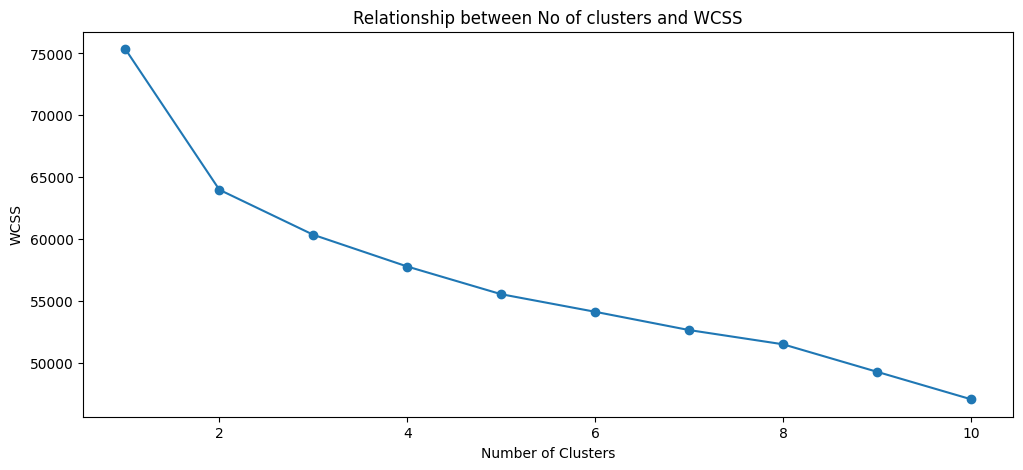

In [75]:
# Visualize the relationship between the number of clusters and WCSS
plt.figure(figsize=(12,5))
plt.plot(K_clusters, wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Relationship between No of clusters and WCSS')
plt.show()


### a.) K Means Clustering

In [76]:
optimal_kclusters= 3

# Fit the model 
kmeans_ml = KMeans(n_clusters=optimal_kclusters, init='k-means++', random_state=42,n_init='auto', max_iter=500)
customer['Kmeans'] = kmeans_ml.fit_predict(customer_scaled)

C:\Users\Esther\AppData\Local\Temp\ipykernel_4164\2549759766.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


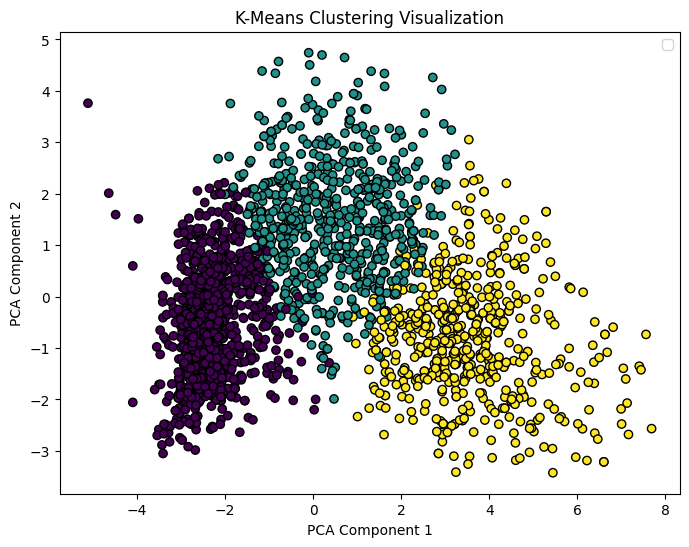

In [77]:
# Visualize the clusters (assuming first two principal components)
plt.figure(figsize=(8,6))
plt.scatter(customer_pca[:, 0], customer_pca[:, 1], c=customer['Kmeans'], cmap='viridis', edgecolors='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering Visualization')
plt.legend()
plt.show()

- Clusters within the Kmeans cluster appear to be well defined.

In [78]:
silhouette_avg = silhouette_score(customer_scaled, customer['Kmeans'])
davies_bouldin = davies_bouldin_score(customer_scaled, customer['Kmeans'])
calinski_harabasz = calinski_harabasz_score(customer_scaled, customer['Kmeans'])

print(f'Silhouette Score for Kmeans: {silhouette_avg:.3f}')
print(f'Davies-Bouldin Index for Kmeans: {davies_bouldin:.3f}')
print(f'Calinski-Harabasz Score for Kmeans: {calinski_harabasz:.3f}')

Silhouette Score for Kmeans: 0.115
Davies-Bouldin Index for Kmeans: 2.647
Calinski-Harabasz Score for Kmeans: 274.860


### b.) Hierarchical clustering

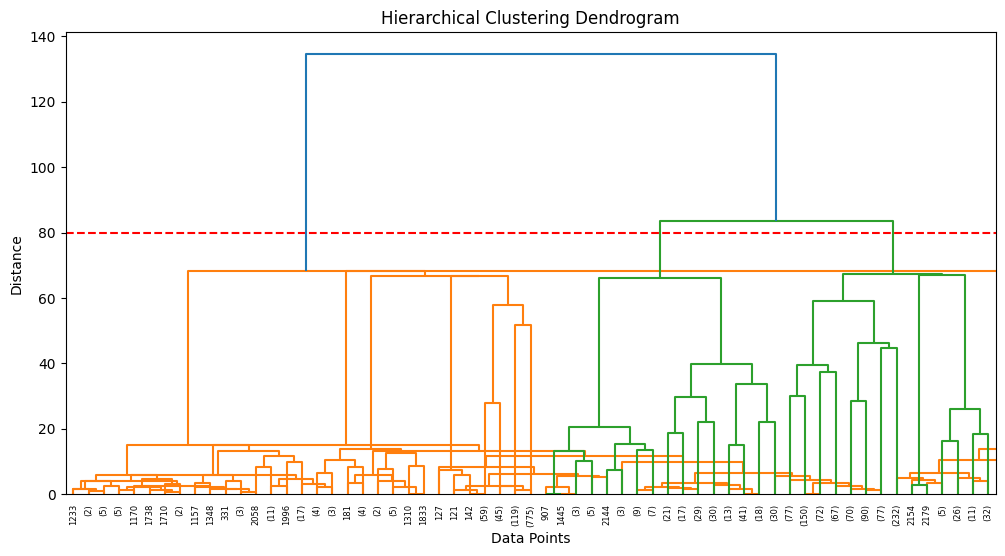

In [79]:
# Perform hierarchical clustering and compute the linkage matrix
linkage_matrix = sch.linkage(customer_scaled, method='ward')  # 'ward' minimizes variance

# Plot the dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.axhline(y=80, color='r', linestyle='--')  # Adjust '500' based on observation
sch.dendrogram(linkage_matrix, truncate_mode='level', p=5)

plt.show()

In [80]:
# Clusters in the hierarchical clustering
optimal_clusters = fcluster(linkage_matrix, t=80, criterion='distance')
print(f"Optimal Clusters: {len(set(optimal_clusters))}")

Optimal Clusters: 3


In [81]:
# Hierarchical Clustering (Agglomerative, with 2 clusters)
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
customer['hierarchical'] = hierarchical.fit(customer_scaled)

labels = hierarchical.labels_

C:\Users\Esther\AppData\Local\Temp\ipykernel_4164\3562590729.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(customer_pca[:, 0], customer_pca[:, 1], labels, cmap='magma')


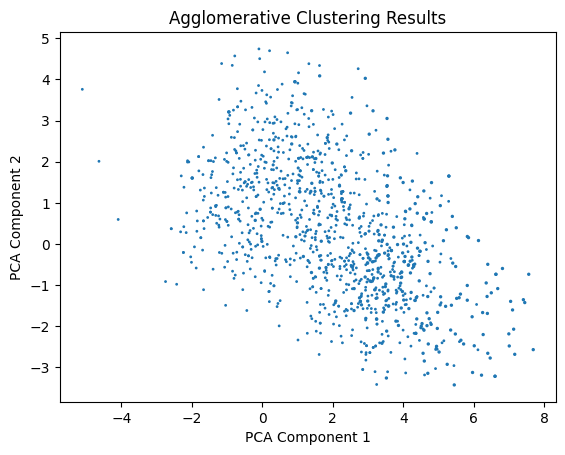

In [82]:
# Agglomerative scatter plots
plt.scatter(customer_pca[:, 0], customer_pca[:, 1], labels, cmap='magma')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Agglomerative Clustering Results")
plt.show()


- The data points appear to be spread out and no clear clusters formed, indicating poor performance of the hierarchical clustering.


In [83]:
# Evaluation of the model
silhouette_avg = silhouette_score(customer_scaled, hierarchical.labels_)
davies_bouldin = davies_bouldin_score(customer_scaled, hierarchical.labels_)
calinski_harabasz = calinski_harabasz_score(customer_scaled, hierarchical.labels_)

print(f'Silhouette Score for Hierarchical: {silhouette_avg:.3f}')
print(f'Davies-Bouldin Index for Hierarchical: {davies_bouldin:.3f}')
print(f'Calinski-Harabasz Score for Hierarchical: {calinski_harabasz:.3f}')

Silhouette Score for Hierarchical: 0.120
Davies-Bouldin Index for Hierarchical: 2.648
Calinski-Harabasz Score for Hierarchical: 220.938


### c.) Gaussian Mixture Models

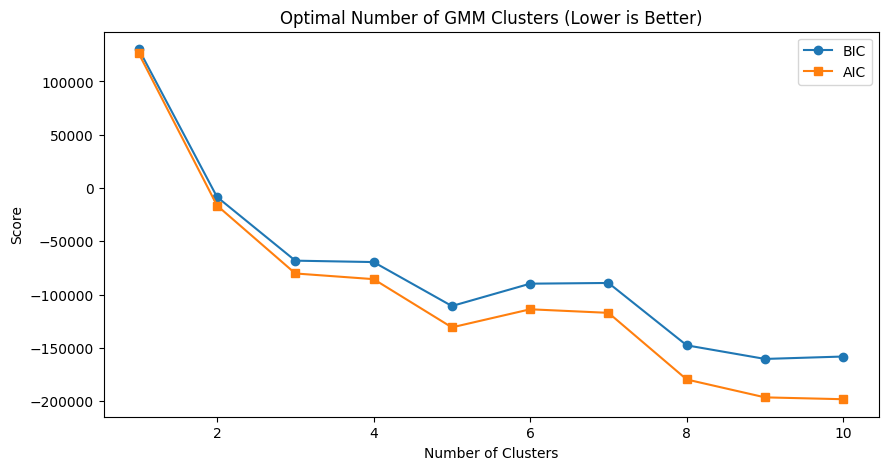

In [84]:
# Determining the optimal number of clusters 
bic_scores = []
aic_scores = []
n_clusters = range(1, 11)

for n in n_clusters:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(customer_scaled)
    bic_scores.append(gmm.bic(customer_scaled))
    aic_scores.append(gmm.aic(customer_scaled))

plt.figure(figsize=(10, 5))
plt.plot(n_clusters, bic_scores, label="BIC", marker="o")
plt.plot(n_clusters, aic_scores, label="AIC", marker="s")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.title("Optimal Number of GMM Clusters (Lower is Better)")
plt.show()


In [85]:
#Gaussian Mixture Model 
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(customer_scaled)
customer['GMM'] = gmm_labels

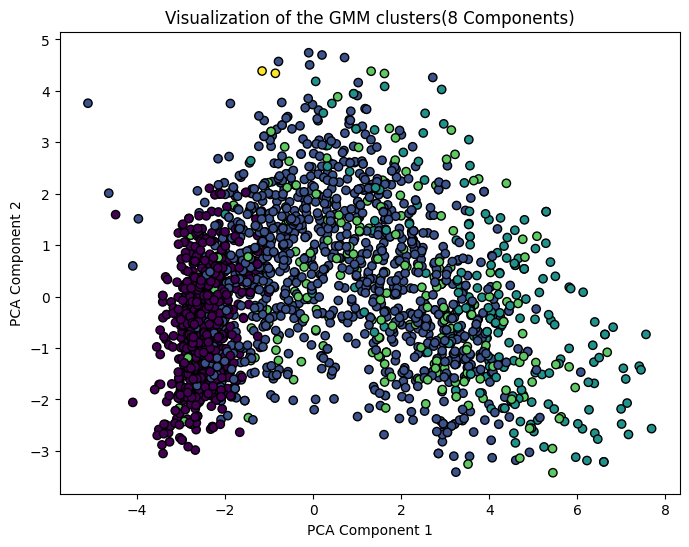

In [86]:
# Visualization of GMM clusters
plt.figure(figsize=(8, 6))
plt.scatter(customer_pca[:, 0], customer_pca[:, 1], c=gmm_labels, cmap='viridis', edgecolors='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Visualization of the GMM clusters(8 Components)")
plt.show()

- Data points are overlapping each other with no clear cluster boundaries.

In [87]:
# Clustering Evaluation Metrics
silhouette_avg = silhouette_score(customer_scaled, gmm_labels)
davies_bouldin = davies_bouldin_score(customer_scaled, gmm_labels)
calinski_harabasz = calinski_harabasz_score(customer_scaled, gmm_labels)

print(f'Silhouette Score for GMM: {silhouette_avg:.3f}')
print(f'Davies-Bouldin Index for GMM: {davies_bouldin:.3f}')
print(f'Calinski-Harabasz Score for GMM: {calinski_harabasz:.3f}')

Silhouette Score for GMM: 0.072
Davies-Bouldin Index for GMM: 3.192
Calinski-Harabasz Score for GMM: 130.671


### d.) DBSCAN

Number of noise points detected: 46


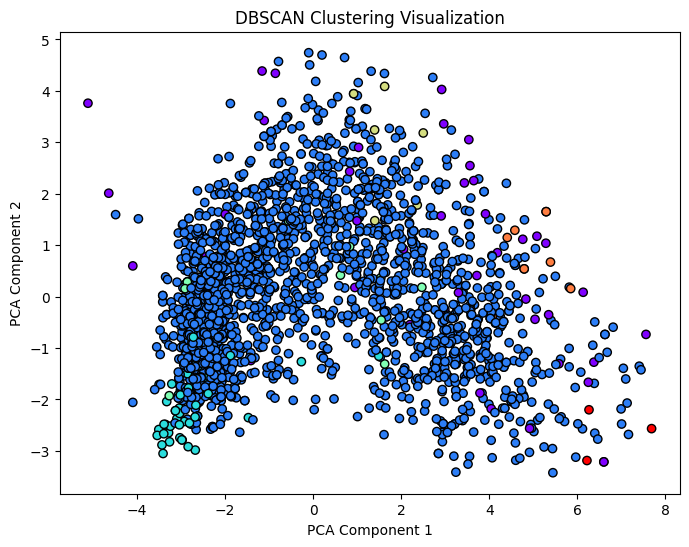

In [88]:
# Performing DBSCAN 
dbscan = DBSCAN(min_samples=5, eps=6.0)
dbscan_labels = dbscan.fit_predict(customer_scaled)
customer['DBSCAN'] = dbscan_labels

# Counting noise points
noise_points = np.sum(dbscan_labels == -1)
print(f"Number of noise points detected: {noise_points}")

# Visualizing DBSCAN Clustering using PCA
plt.figure(figsize=(8, 6))
plt.scatter(customer_pca[:, 0], customer_pca[:, 1], c=dbscan_labels, cmap="rainbow", edgecolors='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering Visualization")
plt.show()



In [89]:
np.unique(dbscan_labels)

array([-1,  0,  1,  2,  3,  4,  5])

In [90]:
silhouette_avg = silhouette_score(customer_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
davies_bouldin = davies_bouldin_score(customer_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
calinski_harabasz = calinski_harabasz_score(customer_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

print(f'Silhouette Score for DBSCAN: {silhouette_avg:.3f}')
print(f'Davies-Bouldin Index for DBSCAN: {davies_bouldin:.3f}')
print(f'Calinski-Harabasz Score for DBSCAN: {calinski_harabasz:.3f}')

Silhouette Score for DBSCAN: 0.198
Davies-Bouldin Index for DBSCAN: 2.334
Calinski-Harabasz Score for DBSCAN: 43.295


In [91]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Marital_Status       2216 non-null   object 
 2   Income               2216 non-null   float64
 3   Kidhome              2216 non-null   int64  
 4   Teenhome             2216 non-null   int64  
 5   Recency              2216 non-null   int64  
 6   MntWines             2216 non-null   int64  
 7   MntFruits            2216 non-null   int64  
 8   MntMeatProducts      2216 non-null   int64  
 9   MntFishProducts      2216 non-null   int64  
 10  MntSweetProducts     2216 non-null   int64  
 11  MntGoldProds         2216 non-null   int64  
 12  NumDealsPurchases    2216 non-null   int64  
 13  NumWebPurchases      2216 non-null   int64  
 14  NumCatalogPurchases  2216 non-null   int64  
 15  NumStorePurchases    2216 non-null   int64 

In [ ]:
# Retain the Kmeans clusters
customer_clusters = customer.drop(columns=['GMM', 'DBSCAN', 'hierarchical'])

In [ ]:
# Distribution of customers within the 3 clusters
customer_clusters.value_counts(['Kmeans'])

Kmeans
0         1000
1          653
2          563
Name: count, dtype: int64

C:\Users\Esther\AppData\Local\Temp\ipykernel_4164\1831021451.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_clusters['Kmeans'].value_counts().index,


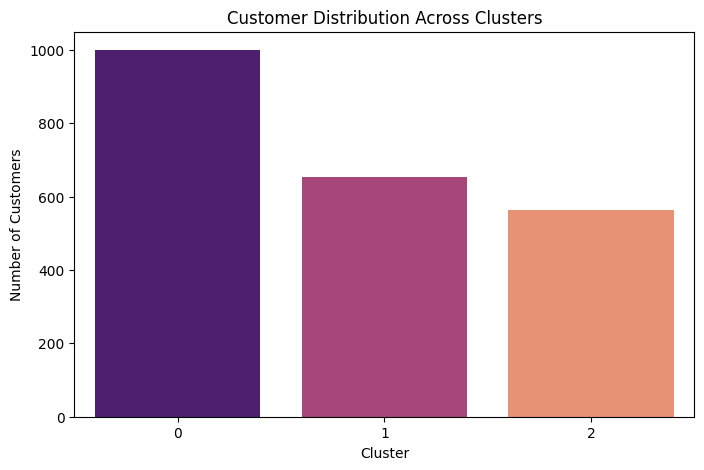

In [98]:
# Bar plot of updated cluster distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=customer_clusters['Kmeans'].value_counts().index, 
            y=customer_clusters['Kmeans'].value_counts().values, palette="magma")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution Across Clusters")
plt.show()



C:\Users\Esther\AppData\Local\Temp\ipykernel_4164\674144376.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Kmeans', y='Income', data=customer_clusters, palette="viridis")


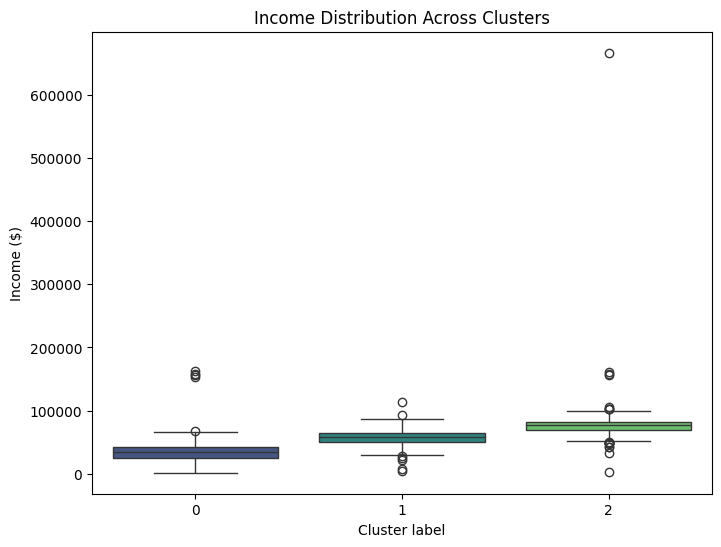

In [101]:
# Box plot to visualize income distribution per cluster
plt.figure(figsize=(8, 6))
sns.boxplot(x='Kmeans', y='Income', data=customer_clusters, palette="viridis")
plt.xlabel("Cluster label")
plt.ylabel("Income ($)")
plt.title("Income Distribution Across Clusters")
plt.show()

C:\Users\Esther\AppData\Local\Temp\ipykernel_4164\716808460.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Kmeans", y="Total_Spending", data=customer_clusters, palette="viridis")


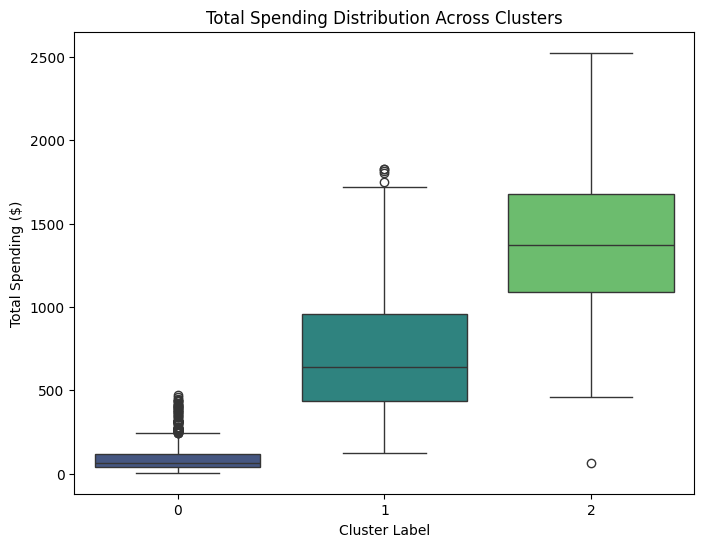

In [102]:
# Creating a Total Spending column
customer_clusters["Total_Spending"] = (
    customer_clusters["MntWines"] + customer_clusters["MntFruits"] + customer_clusters["MntMeatProducts"] +
    customer_clusters["MntFishProducts"] + customer_clusters["MntSweetProducts"] + customer_clusters["MntGoldProds"]
)

# Plotting Spending Habits Across Clusters (assuming we have cluster labels)
plt.figure(figsize=(8, 6))
sns.boxplot(x="Kmeans", y="Total_Spending", data=customer_clusters, palette="viridis")
plt.xlabel("Cluster Label")
plt.ylabel("Total Spending ($)")
plt.title("Total Spending Distribution Across Clusters")
plt.show()


- Customers in the cluster 0 are the lowest spenders compared to cluster 2 who are high spenders.

C:\Users\Esther\AppData\Local\Temp\ipykernel_4164\3160611733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Kmeans", y="Age", data=customer_clusters, palette="viridis", inner="quartile")


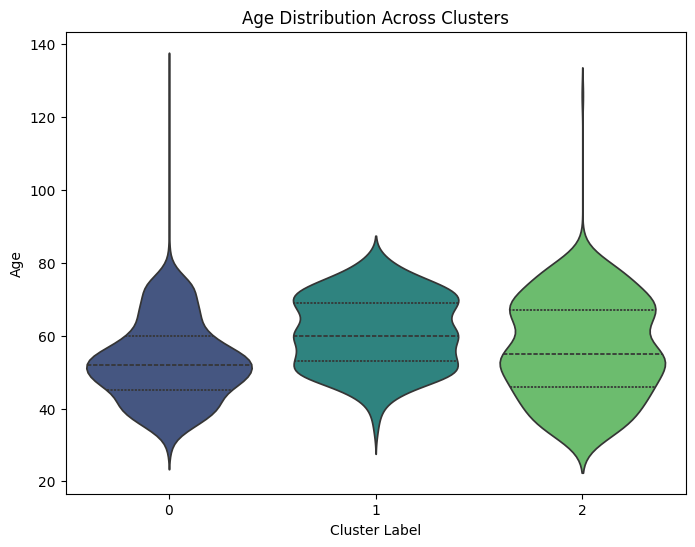

In [103]:
# Violin plot to visualize Age distribution across clusters
plt.figure(figsize=(8, 6))
sns.violinplot(x="Kmeans", y="Age", data=customer_clusters, palette="viridis", inner="quartile")
plt.xlabel("Cluster Label")
plt.ylabel("Age")
plt.title("Age Distribution Across Clusters")
plt.show()

- Cluster 0: Most customers are between 40 and 60 years old and a couple of younger people. This group may represent young professionals or early retirees.

- Cluster 1: Customers in this cluster range between 50 to 75 years old, mainly elderly people. With some who could be retired and moderately high income earners based on their expenditure.

- Cluster 2: Customers within this cluster cut across the board from 35 to 75 years. The density is highest between 50 and 70 years, but some very old customers are present.
